In [ ]:
# Setup
# This cell installs all the dependencies used in this week - imports happen as we go
%%capture
!pip install transformers[sentencepiece] datasets annoy #sacremoses apache_beam mwparserfromhell annoy

# Transformers

Last week you made extenisve use of a single deep learning architecure - the transformer. In 2017 researchers from Google and Toronto University published a paper with the famous title [Attention is all you need](https://arxiv.org/abs/1706.03762) that introduced the transformer architecture and it's features.

Within short time Transformer based models achieved new highscores across NLP benchmarks rendering RNN based models obsolete. They are also the deep learning architecture behind ChatGPT and the announce competitor by Google: Bard.

# Anatomy of Transformers

Transformers can be introduced in multiple ways - most people choose the everything-at-once-approach. But in this course we will introduce Transformers over time.


## The Encoder Transformer

An Encoder Transformer esentially converts a Text into a semantic embedding on which you can train tasks like Classification or NER.

### Encoder "Data-Flow"


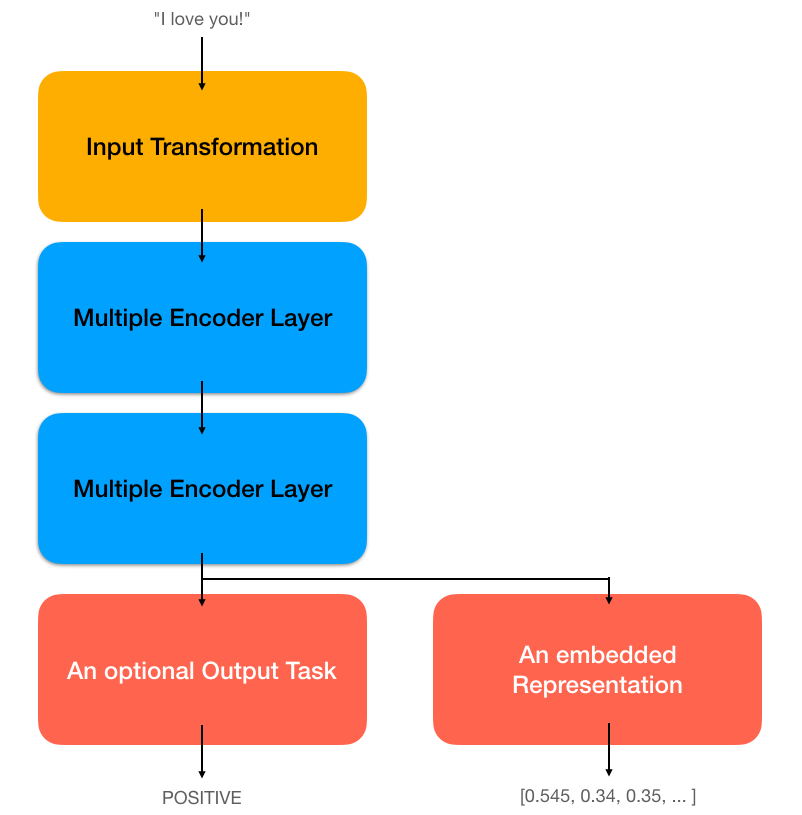

### Refresher: Tokenization

Tokenization is the process of seperating a text into "meaningful" chunks like words and encode them through some kind of on-hot-encoding.

In week 1 we used the CountVectorizer from sklearn to do exactly that.
Let's recap this but use the simpler MultiLabelBinarizer. It automatically creates a bag-of-words e.g. the order of words is lost.

In [ ]:
import numpy as np

sentences = [
    "hello world",
    "I like pizza",
    "I love pizza",
    "I love the world",
    "pizza world",
    "world pizza",
    "hello pizza"
]

sentences_split = [sentence.split() for sentence in sentences]
sentences_split

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer



oh = MultiLabelBinarizer()
oh.fit(sentences_split)
oh.classes_

In [ ]:
oh.transform(sentences_split)

But as we have seen in Week 1 - order matters. Another way to represent these strings that respects order would be the following.

In [ ]:
sentences_oh = []

for sentence in sentences_split:
    sentence_oh = []

    for word in sentence:
        word_oh = oh.transform([[word]])
        sentence_oh.append(word_oh.squeeze())

    sentences_oh.append(np.stack(sentence_oh))

for sentence, sentence_oh in zip(sentences, sentences_oh):
    print(sentence)
    print(sentence_oh)
    print("=================\n")

### The Input Transformation

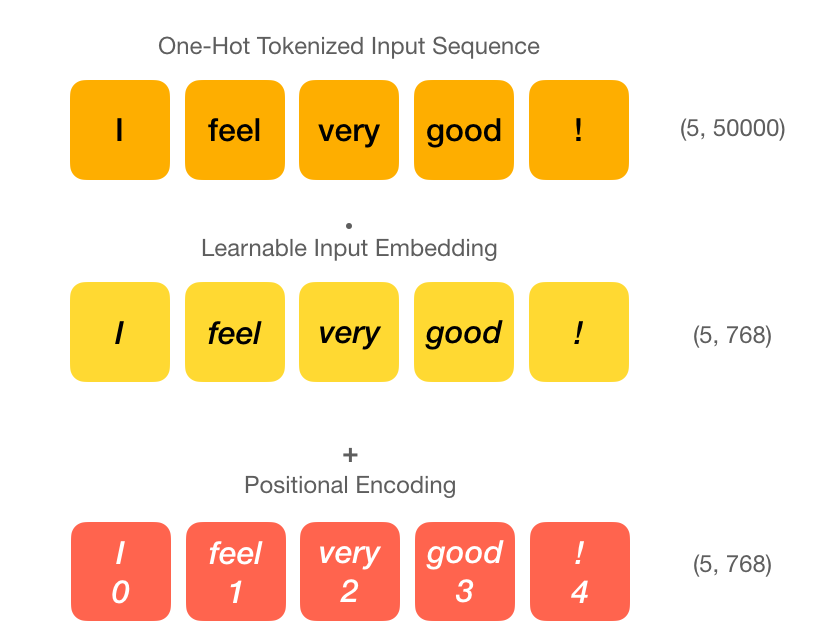

### The Encoder Layer(s)

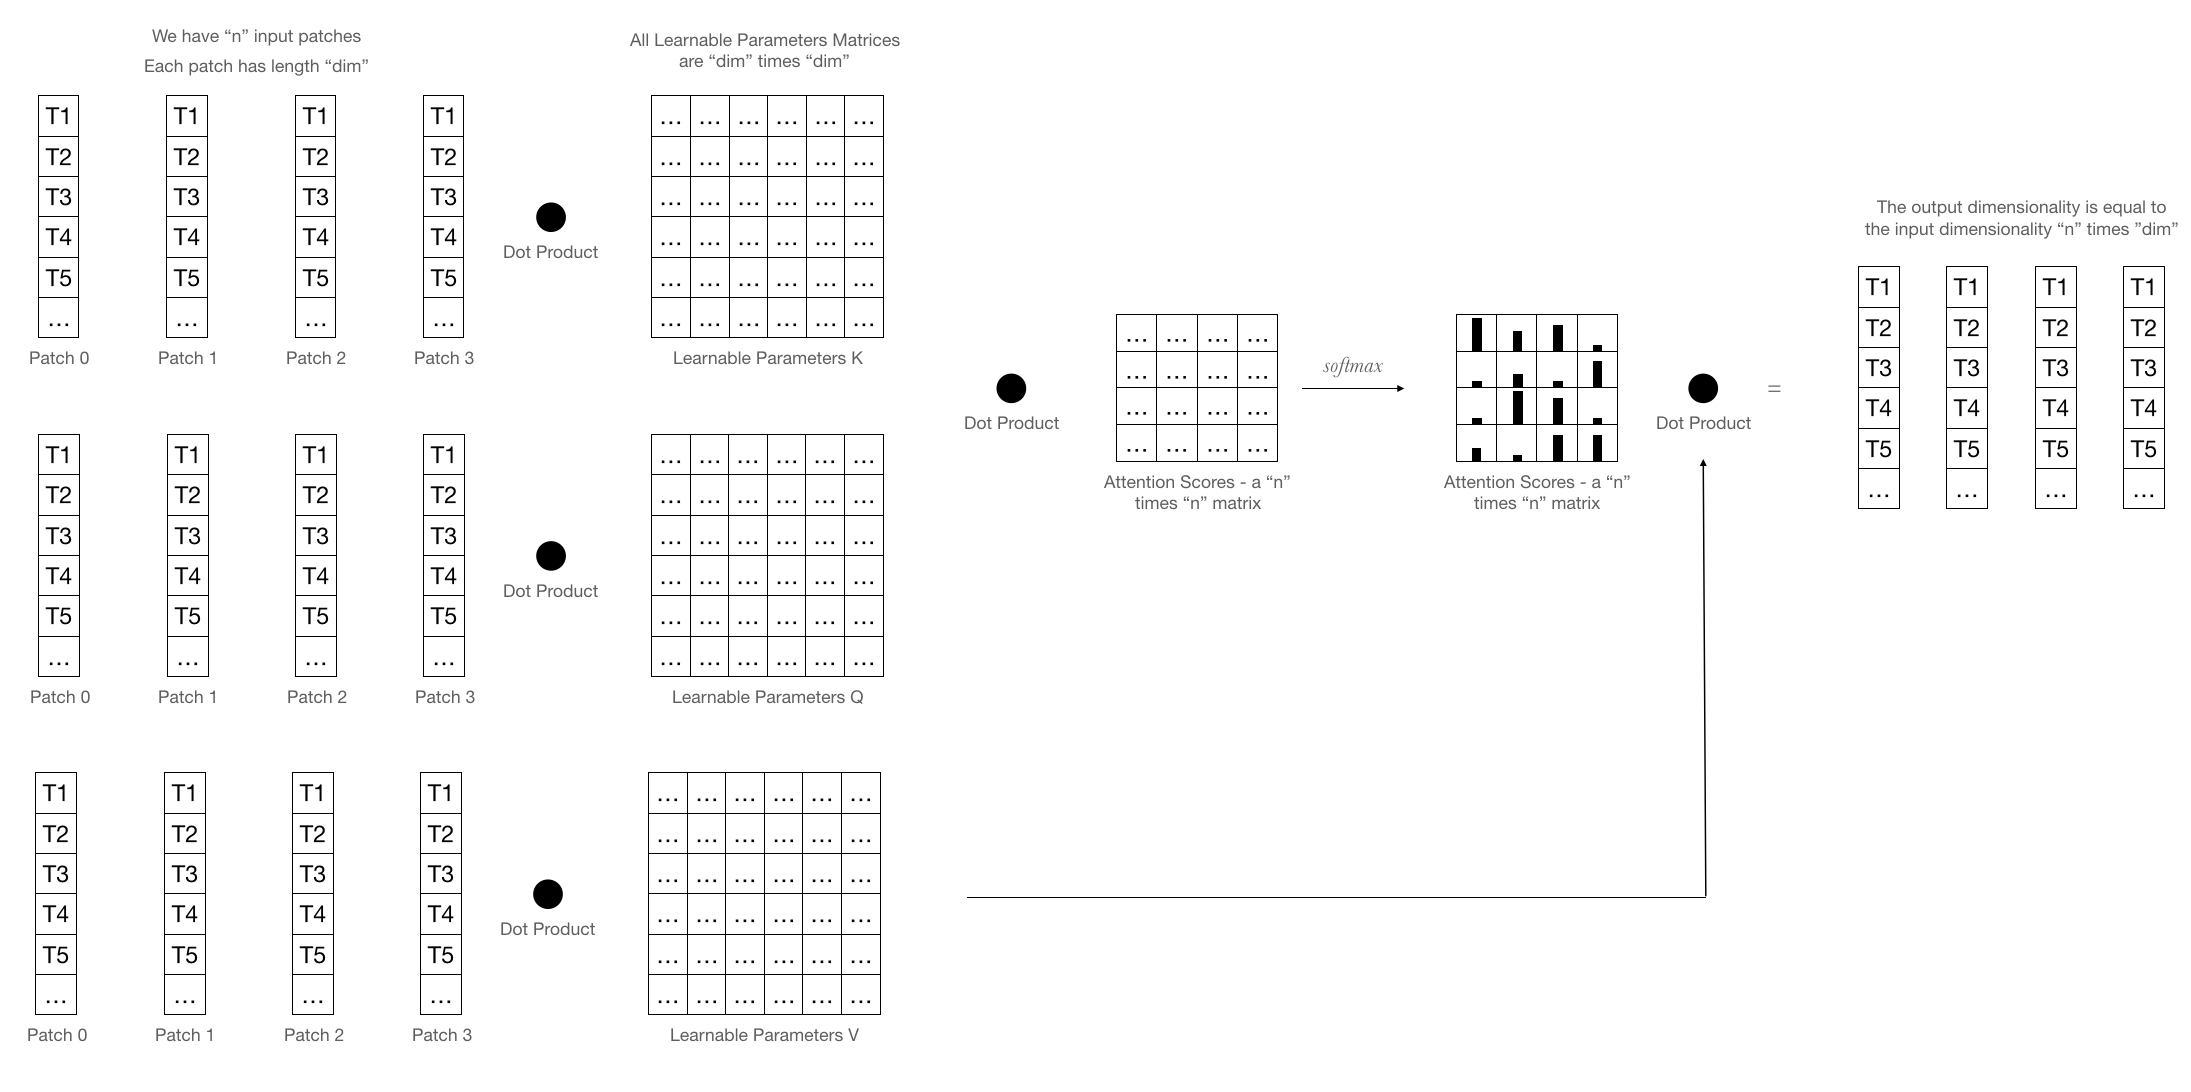

### Output Tasks

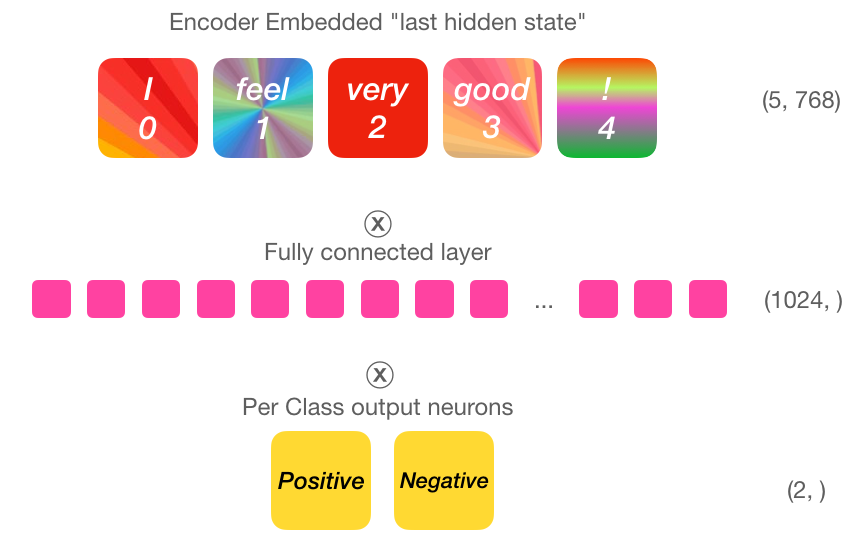

# One more thing about tokenization

Transformer usually do not use word based tokenizer but subword based tokenizer. A subword based tokenizer can choose to split a word into multiple pieces.

In [ ]:
# We can load the Tokenizer of the famous BERT model
from transformers import BertTokenizer


tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

In [ ]:
# Let's tokenize Hello World ...
tokenizer("Hello World")

In [ ]:
# ... and take a look at the splits...
tokenizer.convert_ids_to_tokens(tokenizer("Hello World")["input_ids"])

In [ ]:
# How many tokens are there?
tokenizer.vocab_size

In [ ]:
# Let's try to force a subword split ...
text = "I was just feeding my Lasercats when the one ring arrived from Khazad-dûm."
tokenizer.convert_ids_to_tokens(tokenizer(text)["input_ids"])

In [ ]:
# If you want to dig deeper, just load the vocab into pandas
import pandas as pd


bert_tokens = pd.Series(tokenizer.get_vocab())
bert_tokens.sample(10)

In [ ]:
# Lab: Tokenize your own name

text = "This is the first sentence. Oh this is the second one!"
tokenizer.convert_ids_to_tokens(tokenizer(text)["input_ids"])

# Using an Encoder Transformer

In this section we gradually want to build up our understaning of what we can do with an Encoder Transformer and what this last hidden state is actually about.

## Exploring the hidden state

In [ ]:
# We already loaded the Tokenizer, here comes BERT itself
# This BERT does not have a task output
from transformers import BertModel


bert_model = BertModel.from_pretrained("bert-base-cased")
bert_model = bert_model.cuda()

A common example of how embeddings work is taking a look at the mebeddings of Queen, King and person and their relation.

In [ ]:
# Let's inspect and discuss the outputs of this Encoder only model
text = "Queen"
tokenized_text = tokenizer(text, return_tensors="pt")

# Would you have guessed that the word "Queen" needs 3 tokens to get tokenized?
print(tokenized_text)

In [ ]:
import torch


with torch.no_grad():
    outputs = bert_model(tokenized_text["input_ids"].cuda())

print(outputs["last_hidden_state"].shape)
outputs

In [ ]:
# We can write a function that does the tokenization and model call for us
def embed_in_latent_space(text, model=bert_model, tokenizer=tokenizer):
    tokenized_text = tokenizer(text, return_tensors="pt", max_length=512)

    with torch.no_grad():
        outputs = model(tokenized_text["input_ids"].cuda())

    # Note, that we only keep the first token - why do we do this?
    return outputs["last_hidden_state"].cpu().numpy()[:,0]

Let's try to reduce the number of dimensions to make the latent space more approachable for the human eye. Keep in mind that we are loosing a lot of information in doing so.

In [ ]:
# Any dimensionality reduction is fine to reduce this R^768 to R^2
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

In [ ]:
# Let's create some embeddings
import numpy as np

queen_embedded = embed_in_latent_space("queen")
king_embedded = embed_in_latent_space("king")
cat_embedded = embed_in_latent_space("cat")
dog_embedded = embed_in_latent_space("dog")
tree_embedded = embed_in_latent_space("tree")
monkey_embedded = embed_in_latent_space("monkey")

sub_space = np.concatenate(
    [queen_embedded, king_embedded, cat_embedded,
     dog_embedded, tree_embedded, monkey_embedded], axis=0)

In [ ]:
# One 768 dimension vector per word ...
sub_space.shape

In [ ]:
# ... turns into one 2 dimensional vector per word
redcued_sub_space = pca.fit_transform(sub_space)
redcued_sub_space.shape

In [ ]:
# A scatter plot is the right choice to visualise the embedding space
import seaborn as sns


sns.set(style='white', context='notebook', rc={'figure.figsize':(6, 6), 'figure.dpi':111})

sns.scatterplot(x=redcued_sub_space[:, 0], y=redcued_sub_space[:, 1], s=150,
                style=["queen", "king", "cat", "dog", "tree", "monkey"],
                hue=["queen", "king", "cat", "dog", "tree", "monkey"])

In [ ]:
## Lab: Add any word to the plot above, do typos matter?


# Create Your Own Search Engine

If distance in this space can tell us something about semantic similarity, can we use it to search? Absoluetley, vector search engines are super fast and sepcialized for exactly that task - all you need is a "well conditioned" space. For optimal results one can train a model to transform embeddings to exactly fit that task, but often a pretrained model is enough to achieve reasonable results.

## The Wikipedia Biographie Dataset Data Exploration

This is a dataset including articles about persons only. We want to build a search engine that allows us to search for people through natural language: "Somebody who works with music." or "An artist from Paris."


In [ ]:
# The dataset is quite big - we can use the "streaming" parameter to allow fetching items on demand
from datasets import load_dataset


wikipedia = load_dataset("wiki_bio", streaming=True, split='train')

In [ ]:
# This is a single record
next(iter(wikipedia))

In [ ]:
# And this is the articles text
next(iter(wikipedia))["target_text"]

In [ ]:
# With itertools we can fetch a defined number of articles
import itertools


N = 200
wiki_subset = list(itertools.islice(iter(wikipedia), N))

In [ ]:
# Now they are in a list and can be accessed easily
wiki_subset[0]

So far, we have seen how to embed texts in vector space, but we haven't talked about vector databases. A fast and simple implementation that we can use in plain python without startinf=g is Spotify's Annoy (sic!) index.

In [ ]:
from annoy import AnnoyIndex
import random
from tqdm import tqdm


# This function can run multiple texts through the transformer at once
# Keep in mind that batch processing is only helpful if you use a GPU
def batch_embed_in_latent_space(text, model=bert_model, tokenizer=tokenizer):
    tokenized_text = tokenizer(text, return_tensors="pt", max_length=512, padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(tokenized_text["input_ids"].cuda(), tokenized_text["attention_mask"].cuda())
    return outputs["last_hidden_state"].cpu().numpy()[:,0]


batch_size = 8
n_batches = N // batch_size
dim = 768
unique_id = 0

# Setup the index
t = AnnoyIndex(dim, 'angular')


for i in tqdm(range(n_batches)):
    batched_output = batch_embed_in_latent_space([bio["target_text"] for bio in wiki_subset[i * batch_size : (1 + i) * batch_size]])

    for vector in batched_output:
        t.add_item(unique_id, vector)
        unique_id += 1

t.build(10) # 10 trees
t.save('test.ann')

In [ ]:
# Let's test our search engine
# First we write a query
search_query = "somebody who works with music"

# Than we embed it in the latent space
latent_search_query = embed_in_latent_space(search_query).squeeze()

# These are it's closest neghbors ids - sorted by distance
result_idx = t.get_nns_by_vector(latent_search_query, n=10)

In [ ]:
result_idx

In [ ]:
# Let's print the results
for result in result_idx:
    print(wiki_subset[result]["target_text"])

# A better way to get embeddings

The [SentenceTransformers](https://www.sbert.net/) library is built ontop of HuggingFace transformers and is speciallised in training and using models that create meaningful embeddings.

In [ ]:
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

sentences = ["I am hungry",
    'I want some Pizza',
    'Pizza prices increased in 2022',
    'Economic outview is looking bad'
    ]

embeddings = model.encode(sentences)

for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

In [ ]:
util.cos_sim(embeddings, embeddings)

# Sentiment-Analysis with BERT

In [ ]:
# HuggingFace offers a simple abstraction layer to common downstram tasks
from transformers import pipeline


pipe = pipeline("text-classification")

In [ ]:
pipe(["This restaurant is awesome", "This restaurant is awful"])

# Homework

[Create an OpenAI API Key](https://auth0.openai.com/u/signup/identifier?state=hKFo2SBGYTNXcXZOaDNXTFFod0liMmpiYVo4RjlBaXh2U3dMNqFur3VuaXZlcnNhbC1sb2dpbqN0aWTZIGdUSE13bGx5VzFuWkU0Qzh0YV9CU0p4WF9LX2wwQUFFo2NpZNkgRFJpdnNubTJNdTQyVDNLT3BxZHR3QjNOWXZpSFl6d0Q)

# Next Steps

We hope you start to get a feeling for the power of transformer models. The attention mechanism allows the model to extract exactly what's needed at each step by looking at the entire sentence.

It's like reading a sentence like looking at a picture - position matters but (sub)words do not have to be read in a particular order.

Well, maybe that's exactly what the authors of the 2021 publication [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929) thought. Yes, an Encoder only Transformer can work on images, too

## Super quick look at Vision Transformer (ViT)

This is an NLP course, but you might find this interesting - to use an Encoder Transformer for Vision tasks, you just have to change tokenization for image patches and add your desired task after the encoder layers. The above mentioned paper has a great visualization of this:

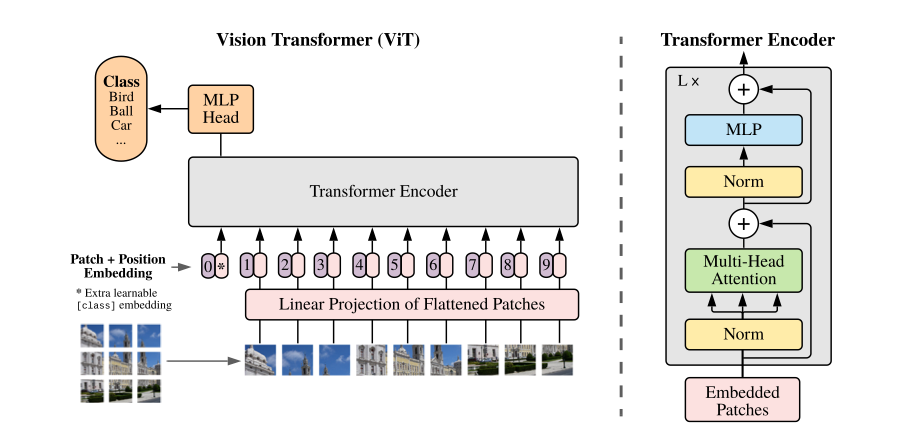

The "Linear Projection of Flattened Patches" is basically the same as the "Input Embedding Layer" of the NLP Transformer.

And since you have Huggingface's transformer lib already loaded...

In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
import requests


url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-384')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-384')

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs, output_hidden_states=True)
logits = outputs.logits

# This pretrained model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

In [ ]:
outputs["hidden_states"][-1].shape

In [ ]:
image